In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from sklearn.utils import class_weight

from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt

# Own code
import import_ipynb
import metadata_options
import models_semantic
import models_nn

Using TensorFlow backend.


importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_semantic.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


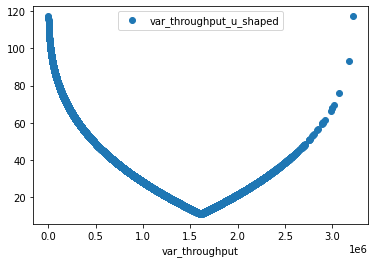

In [3]:
throughput_option = 'TP4'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'RAND_NORM'
k_option_for_tp = 3

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [4]:
######################################
## Model Options ##
######################################
# options: randomforest, logreg

model_name = 'gaussiannb'
models_semantic.MODEL_NAME = model_name

In [5]:
df = df.drop(columns=['Input.msg_id', 'HITId', 'Input.sentence_id', 'Input.convo_id', 'Input.train_test_val',
                     'Input.similar_text_id', 'Input.msg_id', 'Input.timestamp', 'Input.full_text',
                      'Input.speaker', 'Input.reply_to', 
                      'Input.game_score_delta', 'Input.game_score_receiver',
                      'Input.speaker_intention', 'Input.reciever_perception', 'Input.reciever',
                      'Input.absolute_message_index', 'Input.relative_message_index', 'Input.year',
                      'Input.game_score_speaker', 'Input.num_words', 'Input.num_characters', 
                      'Input.sno', 'Input.sno1',
                      'WorkTime.1', 'WorkTime.2', 'WorkTime.3', 'WorkTime.4', 'WorkTime.5',
                      'Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5',
                      'Answer.1gamemove.yes', 'Answer.2reasoning.yes',
                      'Answer.3a_apologies.yes', 'Answer.3a_compliment.yes', 'Answer.3a_personalthoughts.yes',
                      'Answer.3a_reassurance.yes', 'Answer.3rapport.yes', 'Answer.4shareinformation.yes', 'count',
                      'Answer.1gamemove.yes_pc_agree', 'Answer.2reasoning.yes_pc_agree', 
                      'Answer.3a_apologies.yes_pc_agree', 'Answer.3a_compliment.yes_pc_agree',
                      'Answer.3a_personalthoughts.yes_pc_agree', 'Answer.3a_reassurance.yes_pc_agree',
                      'Answer.3rapport.yes_pc_agree', 'Answer.4shareinformation.yes_pc_agree', 
                      'message_id.x', 'message_id.y',
                      'Answer.3a_apologies.yes_label', 'Answer.3a_compliment.yes_label',
                      'Answer.3a_personalthoughts.yes_label', 'Answer.3a_reassurance.yes_label'
                     ])

In [6]:
indices = range(df.shape[0])

In [7]:
# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].tolist()
y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_train = train.drop(columns=['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label',
                              'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label', 'Input.deception_quadrant'])

X_test = test.drop(columns=['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label',
                              'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label', 'Input.deception_quadrant'])

In [8]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].to_numpy()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [9]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


### Individual classifiers are ML models

In [10]:
# Game move classifier
clf_gamemove = models_semantic.get_semantic_model()
clf_gamemove.fit(X_train, y_train_gamemove)
y_pred_gamemove = clf_gamemove.predict(X_train)
y_pred_test_gamemove = clf_gamemove.predict(X_test)
print(classification_report(y_pred_gamemove, y_train_gamemove))

              precision    recall  f1-score   support

         0.0       1.00      0.07      0.14      8674
         1.0       0.05      1.00      0.09       418

    accuracy                           0.12      9092
   macro avg       0.52      0.54      0.12      9092
weighted avg       0.96      0.12      0.14      9092



In [11]:
# Rapport classifier
clf_rapport = models_semantic.get_semantic_model()
clf_rapport.fit(X_train, y_train_rapport)
y_pred_rapport = clf_rapport.predict(X_train)
y_pred_test_rapport = clf_rapport.predict(X_test)
print(classification_report(y_pred_rapport, y_train_rapport))

              precision    recall  f1-score   support

         0.0       1.00      0.14      0.25      8785
         1.0       0.04      0.99      0.07       307

    accuracy                           0.17      9092
   macro avg       0.52      0.57      0.16      9092
weighted avg       0.97      0.17      0.25      9092



In [12]:
# Share Information classifier
clf_shareinfo = models_semantic.get_semantic_model()
clf_shareinfo.fit(X_train, y_train_share_information)
y_pred_shareinfo = clf_shareinfo.predict(X_train)
y_pred_test_shareinfo = clf_shareinfo.predict(X_test)
print(classification_report(y_pred_shareinfo, y_train_share_information))

              precision    recall  f1-score   support

         0.0       1.00      0.17      0.28      8764
         1.0       0.04      0.98      0.08       328

    accuracy                           0.20      9092
   macro avg       0.52      0.58      0.18      9092
weighted avg       0.96      0.20      0.28      9092



In [13]:
# Reasoning classifier
clf_reasoning = models_semantic.get_semantic_model()
clf_reasoning.fit(X_train, y_train_reasoning)
y_pred_reasoning = clf_reasoning.predict(X_train)
y_pred_test_reasoning = clf_reasoning.predict(X_test)
print(classification_report(y_pred_reasoning, y_train_reasoning))

              precision    recall  f1-score   support

         0.0       1.00      0.17      0.30      8804
         1.0       0.04      0.98      0.07       288

    accuracy                           0.20      9092
   macro avg       0.52      0.58      0.18      9092
weighted avg       0.97      0.20      0.29      9092



In [14]:
uni, cnt = np.unique(y_pred_gamemove, return_counts=True)
print(uni, cnt)

[0. 1.] [8674  418]


In [15]:
# Deception classifier
clf_deception = models_semantic.get_semantic_model()
clf_deception.fit(X_train, y_train_deception)
y_pred_deception = clf_reasoning.predict(X_train)
y_pred_test_deception = clf_deception.predict(X_test)
print(classification_report(y_pred_deception, y_train_deception))

              precision    recall  f1-score   support

         0.0       0.97      0.05      0.09      8804
         1.0       0.03      0.95      0.06       288

    accuracy                           0.08      9092
   macro avg       0.50      0.50      0.08      9092
weighted avg       0.94      0.08      0.09      9092



### One hot encodings 

In [16]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(y_pred_gamemove)):  
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = y_pred_gamemove[i]
    pred_obj_1['reasoning'] = y_pred_reasoning[i]
    pred_obj_1['shareinfo'] = y_pred_shareinfo[i]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = y_pred_rapport[i]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [17]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(y_pred_test_gamemove)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = y_pred_test_gamemove[i]
    pred_obj_1['reasoning'] = y_pred_test_reasoning[i]
    pred_obj_1['shareinfo'] = y_pred_test_shareinfo[i]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = y_pred_test_rapport[i]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

In [18]:
# Train weighted encodings
pred_df_full_throughput = pred_df_full.copy()
pred_df_full_worktime = pred_df_full.copy()
pred_df_throughput = pred_df.copy()
pred_df_worktime = pred_df.copy()

df_throughput_keys = df_throughput.keys().to_list()
throughput_values = df_throughput[df_throughput_keys[-1]].take(indices_train).values
pred_df_full_throughput = pred_df_full_throughput.mul(throughput_values, axis=0)
pred_df_throughput = pred_df_throughput.mul(throughput_values, axis=0)

df_worktime_keys = df_worktime.keys().to_list()
worktime_values = df_worktime[df_worktime_keys[-1]].take(indices_train).values
pred_df_full_worktime = pred_df_full_worktime.mul(worktime_values, axis=0)
pred_df_worktime = pred_df_worktime.mul(worktime_values, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values = df_agreement[df_agreement_keys[-1]].take(indices_train).values
    pred_df_full_agreement = pred_df_full_throughput.mul(agreement_values, axis=0)
    pred_df_agreement = pred_df_throughput.mul(agreement_values, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values = df_agreement.take(indices_train)
    pred_df_full_agreement = np.multiply(pred_df_full_throughput, agreement_values)
    agreement_values_wo_rapport = agreement_values.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement = np.multiply(pred_df_throughput, agreement_values_wo_rapport)
    
textlength_values = df_textlength.take(indices_train).values
pred_df_full_textlength = pred_df_full_throughput.mul(textlength_values, axis=0)
pred_df_textlength = pred_df_throughput.mul(textlength_values, axis=0)

df_special_keys = df_special.keys().to_list()
special_values = df_special[df_special_keys[-1]].take(indices_train).values
pred_df_full_special = pred_df_full_throughput.mul(special_values, axis=0)
pred_df_special = pred_df_throughput.mul(special_values, axis=0)

In [19]:
# Test weighted encodings
pred_df_full_throughput_test = pred_test_df_full.copy()
pred_df_full_worktime_test = pred_test_df_full.copy()
pred_df_throughput_test = pred_test_df.copy()
pred_df_worktime_test = pred_test_df.copy()

df_throughput_keys = df_throughput.keys().to_list()
throughput_values_test = df_throughput[df_throughput_keys[-1]].take(indices_test).values
pred_df_full_throughput_test = pred_df_full_throughput_test.mul(throughput_values_test, axis=0)
pred_df_throughput_test = pred_df_throughput_test.mul(throughput_values_test, axis=0)

df_worktime_keys = df_worktime.keys().to_list()
worktime_values_test = df_worktime[df_worktime_keys[-1]].take(indices_test).values
pred_df_full_worktime_test = pred_df_full_worktime_test.mul(worktime_values_test, axis=0)
pred_df_worktime_test = pred_df_worktime_test.mul(worktime_values_test, axis=0)

df_agreement_keys = df_agreement.keys().to_list()
if len(df_agreement_keys) == 5:
    agreement_values_test = df_agreement[df_agreement_keys[-1]].take(indices_test).values
    pred_df_full_agreement_test = pred_df_full_throughput_test.mul(agreement_values_test, axis=0)
    pred_df_agreement_test = pred_df_throughput_test.mul(agreement_values_test, axis=0)
elif len(df_agreement_keys) == 4:
    agreement_values_test = df_agreement.take(indices_test)
    pred_df_full_agreement_test = np.multiply(pred_df_full_throughput_test, agreement_values_test)
    agreement_values_wo_rapport_test = agreement_values_test.drop(columns=['Answer.3rapport.yes_pc_agree'])
    pred_df_agreement_test = np.multiply(pred_df_throughput_test, agreement_values_wo_rapport_test)
    
textlength_values_test = df_textlength.take(indices_test).values
pred_df_full_textlength_test = pred_df_full_throughput_test.mul(textlength_values_test, axis=0)
pred_df_textlength_test = pred_df_throughput_test.mul(textlength_values_test, axis=0)

df_special_keys = df_special.keys().to_list()
special_values_test = df_special[df_special_keys[-1]].take(indices_test).values
pred_df_full_special_test = pred_df_full_throughput_test.mul(special_values_test, axis=0)
pred_df_special_test = pred_df_throughput_test.mul(special_values_test, axis=0)

### Joint model is dense layer

In [20]:
y_train_deception = np.array(y_train_deception)
y_test_deception = np.array(y_test_deception)

y_train_rapport = np.array(y_train_rapport)
y_test_rapport = np.array(y_test_rapport)

In [21]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df_full,y_test_deception),
                    class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.0969 - f1_m: 0.0942 - precision_m: 0.8711 - recall_m: 0.0536 - val_loss: 0.6926 - val_acc: 0.0862 - val_f

143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.9186 - f1_m: 0.9394 - precision_m: 0.9461 - recall_m: 0.9569 - val_loss: 0.6926 - val_acc: 0.0880 - val_f1_m: 0.0798 - val_precision_m: 0.8461 - val_recall_m: 0.0425
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.2124 - f1_m: 0.2172 - precision_m: 0.9082 - recall_m: 0.1812 - val_loss: 0.6977 - val_acc: 0.0880 - val_f1_m: 0.0798 - val_precision_m: 0.8461 - val_recall_m: 0.0425
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6925 - acc: 0.0977 - f1_m: 0.0990 - precision_m: 0.9179 - recall_m: 0.0529 - val_loss: 0.6962 - val_acc: 0.0880 - val_f1_m: 0.0798 - val_precision_m: 0.8461 - val_recall_m: 0.0425
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.3011 - f1_m: 0.3084 - precision_m: 0.9316 - recall_m: 0.2788 - val_loss: 0.6931 - val_acc: 0.0880 - val_f1_m: 0.0798 - val_precision_m: 0.8461 - val_r

In [22]:
full_pred = joint_full_model.predict(pred_df_full)
# full_pred = np.argmax(full_pred, axis=1)
full_pred = full_pred.round()

full_pred_test = joint_full_model.predict(pred_test_df_full)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

In [23]:
uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

[0. 1.] [2176   98]


In [24]:
precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

(0.4990761929771909, 0.4991864345183032, 0.08791617674361037, None)

In [25]:
y_train_rapport = np.array(y_train_rapport)
y_test_rapport = np.array(y_test_rapport)

print('Joint full model with one hot encoding, predicting rapport')
joint_full_model_rapport = models_nn.create_joint_model(pred_df)
joint_full_model_rapport.summary()
history = joint_full_model_rapport.fit(x=pred_df, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df,y_test_rapport), class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.1866 - f1_m: 0.1058 - precision_m: 0.8320 - recall_m: 0.0635 - val_loss: 0.6925 - val_acc: 0.1618 - val_f1_

143/143 [==============================] - 0s 3ms/step - loss: 0.6914 - acc: 0.1940 - f1_m: 0.1321 - precision_m: 0.8972 - recall_m: 0.0723 - val_loss: 0.6977 - val_acc: 0.1702 - val_f1_m: 0.0998 - val_precision_m: 0.8694 - val_recall_m: 0.0538
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6915 - acc: 0.1940 - f1_m: 0.1295 - precision_m: 0.9015 - recall_m: 0.0709 - val_loss: 0.6948 - val_acc: 0.1702 - val_f1_m: 0.0998 - val_precision_m: 0.8694 - val_recall_m: 0.0538
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6914 - acc: 0.1940 - f1_m: 0.1297 - precision_m: 0.8884 - recall_m: 0.0707 - val_loss: 0.6954 - val_acc: 0.1702 - val_f1_m: 0.0998 - val_precision_m: 0.8694 - val_recall_m: 0.0538
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6914 - acc: 0.1940 - f1_m: 0.1295 - precision_m: 0.8821 - recall_m: 0.0710 - val_loss: 0.6946 - val_acc: 0.1702 - val_f1_m: 0.0998 - val_precision_m: 0.8694 - val_r

In [26]:
full_pred = joint_full_model_rapport.predict(pred_df)
# full_pred = np.argmax(full_pred, axis=1)
full_pred = full_pred.round()

full_pred_test = joint_full_model_rapport.predict(pred_test_df)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

(0.5074463708940216, 0.5033681751382157, 0.16546563629521366, None)

In [27]:
uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

[0. 1.] [2152  122]


In [28]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_throughput_test,y_test_deception), class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6940 - acc: 0.3835 - f1_m: 0.3807 - precision_m: 0.3855 - recall_m: 0.3763 - val_loss: 0.6988 -

Epoch 28/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6922 - acc: 0.9198 - f1_m: 0.9581 - precision_m: 0.9523 - recall_m: 0.9647 - val_loss: 0.6926 - val_acc: 0.9213 - val_f1_m: 0.9589 - val_precision_m: 0.9492 - val_recall_m: 0.9695
Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.9194 - f1_m: 0.9578 - precision_m: 0.9520 - recall_m: 0.9644 - val_loss: 0.6905 - val_acc: 0.9226 - val_f1_m: 0.9596 - val_precision_m: 0.9492 - val_recall_m: 0.9708
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.9211 - f1_m: 0.9588 - precision_m: 0.9521 - recall_m: 0.9662 - val_loss: 0.6916 - val_acc: 0.9217 - val_f1_m: 0.9592 - val_precision_m: 0.9492 - val_recall_m: 0.9699
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.7961 - f1_m: 0.8265 - precision_m: 0.9025 - recall_m: 0.8297 - val_loss: 0.6912 - val_acc: 0.9230 - val_f1_m: 0.9598 - val_precision_m: 0.

In [29]:
full_pred = joint_full_model.predict(pred_df_full)
# full_pred = np.argmax(full_pred, axis=1)
full_pred = full_pred.round()

full_pred_test = joint_full_model.predict(pred_test_df_full)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

(0.4949515430144027, 0.49542421038720763, 0.4951345907045503, None)

In [30]:
uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

[0. 1.] [ 101 2173]


In [31]:
y_train_rapport = np.array(y_train_rapport).astype(int)
y_test_rapport = np.array(y_test_rapport).astype(int)

In [32]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model_rapport = models_nn.create_joint_model(pred_df_throughput)
joint_full_model_rapport.summary()
history = joint_full_model_rapport.fit(x=pred_df_throughput, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_throughput_test,y_test_rapport), class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6930 - acc: 0.7116 - f1_m: 0.7511 - precision_m: 0.8443 - recall_m: 0.7978 - val_loss: 0.6918 - v

143/143 [==============================] - 1s 4ms/step - loss: 0.6900 - acc: 0.1932 - f1_m: 0.1296 - precision_m: 0.8962 - recall_m: 0.0711 - val_loss: 0.6936 - val_acc: 0.1693 - val_f1_m: 0.0980 - val_precision_m: 0.8671 - val_recall_m: 0.0529
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6899 - acc: 0.1929 - f1_m: 0.1292 - precision_m: 0.9023 - recall_m: 0.0707 - val_loss: 0.6936 - val_acc: 0.1693 - val_f1_m: 0.0980 - val_precision_m: 0.8671 - val_recall_m: 0.0529
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6900 - acc: 0.2206 - f1_m: 0.1650 - precision_m: 0.8954 - recall_m: 0.1117 - val_loss: 0.6933 - val_acc: 0.1702 - val_f1_m: 0.0998 - val_precision_m: 0.8694 - val_recall_m: 0.0538
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6899 - acc: 0.1928 - f1_m: 0.1266 - precision_m: 0.8696 - recall_m: 0.0692 - val_loss: 0.6963 - val_acc: 0.1680 - val_f1_m: 0.0953 - val_precision_m: 0.8671 - val_r

In [33]:
full_pred_test = joint_full_model_rapport.predict(pred_df_throughput_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

(0.5048440973336662, 0.5021061862437181, 0.16297192661621368, None)

In [34]:
uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

[0. 1.] [2157  117]


In [35]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_worktime_test,y_test_deception), class_weight=deception_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_full_worktime_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6931 - acc: 0.0742 - f1_m: 0.0423 - precision_m: 0.5698 - recall_m: 0.0290 - val_loss: 0.6931 - 

143/143 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.7909 - f1_m: 0.8053 - precision_m: 0.8191 - recall_m: 0.8259 - val_loss: 0.6901 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.3425 - f1_m: 0.3234 - precision_m: 0.4226 - recall_m: 0.3307 - val_loss: 0.6902 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.4729 - f1_m: 0.4592 - precision_m: 0.5210 - recall_m: 0.4702 - val_loss: 0.6918 - val_acc: 0.0523 - val_f1_m: 0.0063 - val_precision_m: 0.1944 - val_recall_m: 0.0032
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.2513 - f1_m: 0.2224 - precision_m: 0.3649 - recall_m: 0.2264 - val_loss: 0.6923 - val_acc: 0.0528 - val_f1_m: 0.0072 - val_precision_m: 0.2222 - val_r

In [36]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_worktime_test,y_test_rapport), class_weight=rapport_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_worktime_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.5625 - f1_m: 0.5543 - precision_m: 0.5280 - recall_m: 0.6012 - val_loss: 0.6928 - va

143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5036 - f1_m: 0.4758 - precision_m: 0.6620 - recall_m: 0.5098 - val_loss: 0.6937 - val_acc: 0.1350 - val_f1_m: 0.0193 - val_precision_m: 0.3611 - val_recall_m: 0.0100
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.1920 - f1_m: 0.0888 - precision_m: 0.5487 - recall_m: 0.0788 - val_loss: 0.6919 - val_acc: 0.8712 - val_f1_m: 0.9299 - val_precision_m: 0.8698 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.8604 - f1_m: 0.9209 - precision_m: 0.8564 - recall_m: 1.0000 - val_loss: 0.6908 - val_acc: 0.8712 - val_f1_m: 0.9299 - val_precision_m: 0.8698 - val_recall_m: 1.0000
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.2659 - f1_m: 0.1702 - precision_m: 0.4898 - recall_m: 0.1719 - val_loss: 0.6959 - val_acc: 0.1332 - val_f1_m: 0.0125 - val_precision_m: 0.2685 - val_r

In [37]:
print('Joint full model with one hot encoding, predicting deception, weighted by agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_agreement_test,y_test_deception), class_weight=deception_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_full_agreement_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting deception, weighted by agreement
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.4273 - f1_m: 0.4254 - precision_m: 0.4302 - recall_m: 0.4212 - val_loss: 0.6954 -

143/143 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.9083 - f1_m: 0.9508 - precision_m: 0.9502 - recall_m: 0.9525 - val_loss: 0.6933 - val_acc: 0.9120 - val_f1_m: 0.9539 - val_precision_m: 0.9492 - val_recall_m: 0.9595
Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.8427 - f1_m: 0.8762 - precision_m: 0.8775 - recall_m: 0.8756 - val_loss: 0.6950 - val_acc: 0.0493 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6930 - acc: 0.7581 - f1_m: 0.7904 - precision_m: 0.7975 - recall_m: 0.7901 - val_loss: 0.6939 - val_acc: 0.9125 - val_f1_m: 0.9542 - val_precision_m: 0.9493 - val_recall_m: 0.9600
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.9059 - f1_m: 0.9504 - precision_m: 0.9521 - recall_m: 0.9496 - val_loss: 0.6934 - val_acc: 0.9120 - val_f1_m: 0.9539 - val_precision_m: 0.

In [38]:
print('Joint full model with one hot encoding, predicting rapport, weighted by agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_agreement_test,y_test_rapport), class_weight=rapport_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_agreement_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting rapport, weighted by agreement
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6935 - acc: 0.2097 - f1_m: 0.0944 - precision_m: 0.0886 - recall_m: 0.1012 - val_loss: 0.6936 - v

143/143 [==============================] - 1s 4ms/step - loss: 0.6887 - acc: 0.1887 - f1_m: 0.1166 - precision_m: 0.8977 - recall_m: 0.0633 - val_loss: 0.6924 - val_acc: 0.1649 - val_f1_m: 0.0868 - val_precision_m: 0.8573 - val_recall_m: 0.0465
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6887 - acc: 0.1886 - f1_m: 0.1152 - precision_m: 0.8714 - recall_m: 0.0626 - val_loss: 0.6928 - val_acc: 0.1649 - val_f1_m: 0.0861 - val_precision_m: 0.8629 - val_recall_m: 0.0460
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6886 - acc: 0.1871 - f1_m: 0.1130 - precision_m: 0.8901 - recall_m: 0.0611 - val_loss: 0.6932 - val_acc: 0.1645 - val_f1_m: 0.0852 - val_precision_m: 0.8629 - val_recall_m: 0.0455
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6886 - acc: 0.1873 - f1_m: 0.1126 - precision_m: 0.8930 - recall_m: 0.0609 - val_loss: 0.6932 - val_acc: 0.1640 - val_f1_m: 0.0843 - val_precision_m: 0.8629 - val_r

In [39]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength_test)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_textlength_test,y_test_deception), class_weight=deception_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_full_textlength_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.1122 - f1_m: 0.0769 - precision_m: 0.1285 - recall_m: 0.0781 - val_loss: 0.6929

143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.1609 - f1_m: 0.1335 - precision_m: 0.6364 - recall_m: 0.1247 - val_loss: 0.6945 - val_acc: 0.0642 - val_f1_m: 0.0346 - val_precision_m: 0.6273 - val_recall_m: 0.0179
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.4597 - f1_m: 0.4569 - precision_m: 0.7297 - recall_m: 0.4619 - val_loss: 0.6926 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.1278 - f1_m: 0.1013 - precision_m: 0.5133 - recall_m: 0.0940 - val_loss: 0.6927 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6937 - acc: 0.8514 - f1_m: 0.8632 - precision_m: 0.9150 - recall_m: 0.8833 - val_loss: 0.6955 - val_acc: 0.0545 - val_f1_m: 0.0126 - val_precision_m: 0.2778 - val_r

In [40]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_textlength_test,y_test_rapport), class_weight=rapport_class_weight_dict)

full_pred_test = joint_full_model.predict(pred_df_textlength_test)
# full_pred_test = np.argmax(full_pred_test, axis=1)
full_pred_test = full_pred_test.round()

print(precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro'))

uni, cnt = np.unique(full_pred_test, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting rapport, weighted by text length
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.4264 - f1_m: 0.3813 - precision_m: 0.6438 - recall_m: 0.4065 - val_loss: 0.6928 -

143/143 [==============================] - 0s 3ms/step - loss: 0.6908 - acc: 0.1861 - f1_m: 0.1136 - precision_m: 0.8630 - recall_m: 0.0619 - val_loss: 0.6959 - val_acc: 0.1649 - val_f1_m: 0.0884 - val_precision_m: 0.8375 - val_recall_m: 0.0475
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6909 - acc: 0.1956 - f1_m: 0.1248 - precision_m: 0.8795 - recall_m: 0.0787 - val_loss: 0.6946 - val_acc: 0.1627 - val_f1_m: 0.0839 - val_precision_m: 0.8236 - val_recall_m: 0.0450
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6906 - acc: 0.1902 - f1_m: 0.1209 - precision_m: 0.8976 - recall_m: 0.0660 - val_loss: 0.6912 - val_acc: 0.1689 - val_f1_m: 0.0973 - val_precision_m: 0.8671 - val_recall_m: 0.0524
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6908 - acc: 0.3430 - f1_m: 0.3055 - precision_m: 0.8842 - recall_m: 0.2812 - val_loss: 0.6968 - val_acc: 0.1649 - val_f1_m: 0.0884 - val_precision_m: 0.8375 - val_r

In [41]:
## Joint full model with semantic model, predicting deception
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_full, y_train_deception)
y_pred_deception = clf_joint.predict(pred_df_full)
y_pred_test_deception = clf_joint.predict(pred_test_df_full)
print(classification_report(y_pred_test_deception, y_test_deception))

precision_recall_fscore_support(y_test_deception, y_pred_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97      2274

    accuracy                           0.95      2274
   macro avg       0.50      0.48      0.49      2274
weighted avg       1.00      0.95      0.97      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [42]:
## Joint full model with semantic model, predicting rapport
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df, y_train_rapport)
y_pred_repport = clf_joint.predict(pred_df)
y_pred_test_rapport = clf_joint.predict(pred_test_df)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_test_rapport, y_pred_test_rapport, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93      2274

    accuracy                           0.87      2274
   macro avg       0.50      0.44      0.47      2274
weighted avg       1.00      0.87      0.93      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4355760773966579, 0.5, 0.4655699177438308, None)

In [43]:
## Joint full model with semantic model, predicting deception, weighted by throughput
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_full_throughput, y_train_deception)
y_pred_deception = clf_joint.predict(pred_df_full_throughput)
y_pred_test_deception = clf_joint.predict(pred_df_full_throughput_test)
print(classification_report(y_pred_test_deception, y_test_deception))

precision_recall_fscore_support(y_test_deception, y_pred_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.99      0.95      0.97      2262

    accuracy                           0.95      2274
   macro avg       0.50      0.48      0.49      2274
weighted avg       0.99      0.95      0.97      2274



(0.47524314765694076, 0.49722479185938945, 0.48598553345388784, None)

In [44]:
## Joint full model with semantic model, predicting rapport, weighted by throughput
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_throughput, y_train_rapport)
y_pred_rapport = clf_joint.predict(pred_df_throughput)
y_pred_test_rapport = clf_joint.predict(pred_df_throughput_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_test_rapport, y_pred_test_rapport, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93      2274

    accuracy                           0.87      2274
   macro avg       0.50      0.44      0.47      2274
weighted avg       1.00      0.87      0.93      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4355760773966579, 0.5, 0.4655699177438308, None)

In [45]:
## Joint full model with semantic model, predicting deception, weighted by worktime
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_full_worktime, y_train_deception)
y_pred_test = clf_joint.predict(pred_df_full_worktime_test)
print(classification_report(y_pred_test, y_test_deception))

precision_recall_fscore_support(y_pred_test, y_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.98      0.05      0.09      2222
           1       0.02      0.96      0.05        52

    accuracy                           0.07      2274
   macro avg       0.50      0.51      0.07      2274
weighted avg       0.96      0.07      0.09      2274



(0.5026347958239725, 0.5055217060167555, 0.06971295077132433, None)

In [46]:
## Joint full model with semantic model, predicting rapport, weighted by worktime
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_worktime, y_train_rapport)
y_pred_test_rapport = clf_joint.predict(pred_df_worktime_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_pred_test_rapport, y_test_rapport, average='macro')

              precision    recall  f1-score   support

           0       0.98      0.13      0.23      2225
           1       0.02      0.88      0.04        49

    accuracy                           0.15      2274
   macro avg       0.50      0.50      0.14      2274
weighted avg       0.96      0.15      0.22      2274



(0.5006141966428511, 0.5032698922265535, 0.13516161469928828, None)

In [47]:
## Joint full model with semantic model, predicting deception, weighted by agreement
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_full_agreement, y_train_deception)
y_pred_test = clf_joint.predict(pred_df_full_agreement_test)
print(classification_report(y_pred_test, y_test_deception))

precision_recall_fscore_support(y_pred_test, y_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.99      0.95      0.97      2262

    accuracy                           0.95      2274
   macro avg       0.50      0.48      0.49      2274
weighted avg       0.99      0.95      0.97      2274



(0.49722479185938945, 0.47524314765694076, 0.48598553345388784, None)

In [48]:
## Joint full model with semantic model, predicting rapport, weighted by agreement
clf_joint = models_semantic.get_semantic_model()
clf_joint.fit(pred_df_agreement, y_train_rapport)
y_pred_test_rapport = clf_joint.predict(pred_df_agreement_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_pred_test_rapport, y_test_rapport, average='macro')

              precision    recall  f1-score   support

           0       0.95      0.13      0.23      2152
           1       0.05      0.89      0.10       122

    accuracy                           0.17      2274
   macro avg       0.50      0.51      0.17      2274
weighted avg       0.90      0.17      0.22      2274



(0.5033681751382157, 0.5074463708940216, 0.16546563629521366, None)

## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

In [49]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
                               class_weight=deception_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_full_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
print(precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro'))
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6929 - acc: 0.2492 - f1_m: 0.2309 - precision_m: 0.2457 - recall_m: 0.2296 - val_loss: 0.6

143/143 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.9194 - f1_m: 0.9579 - precision_m: 0.9516 - recall_m: 0.9650 - val_loss: 0.6893 - val_acc: 0.9274 - val_f1_m: 0.9621 - val_precision_m: 0.9510 - val_recall_m: 0.9739
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6922 - acc: 0.9232 - f1_m: 0.9590 - precision_m: 0.9516 - recall_m: 0.9674 - val_loss: 0.6896 - val_acc: 0.9274 - val_f1_m: 0.9621 - val_precision_m: 0.9510 - val_recall_m: 0.9739
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.9199 - f1_m: 0.9571 - precision_m: 0.9501 - recall_m: 0.9653 - val_loss: 0.6903 - val_acc: 0.9279 - val_f1_m: 0.9623 - val_precision_m: 0.9510 - val_recall_m: 0.9744
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.9187 - f1_m: 0.9566 - precision_m: 0.9501 - recall_m: 0.9639 - val_loss: 0.6927 - val_acc: 0.9266 - val_f1_m: 0.9616 - val_precision_m: 0.9509 - val_r

In [50]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
                               class_weight=rapport_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
print(precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro'))
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

Joint full model with one hot encoding, predicting rapport, weighted by special option
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 6ms/step - loss: 0.6927 - acc: 0.1857 - f1_m: 0.1056 - precision_m: 0.8131 - recall_m: 0.0642 - val_loss: 0.692

143/143 [==============================] - 0s 3ms/step - loss: 0.6913 - acc: 0.2512 - f1_m: 0.1937 - precision_m: 0.8708 - recall_m: 0.1539 - val_loss: 0.6980 - val_acc: 0.1631 - val_f1_m: 0.0848 - val_precision_m: 0.8580 - val_recall_m: 0.0454
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6913 - acc: 0.1872 - f1_m: 0.1128 - precision_m: 0.8638 - recall_m: 0.0611 - val_loss: 0.6963 - val_acc: 0.1636 - val_f1_m: 0.0857 - val_precision_m: 0.8595 - val_recall_m: 0.0459
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6912 - acc: 0.2061 - f1_m: 0.1407 - precision_m: 0.8617 - recall_m: 0.0949 - val_loss: 0.6875 - val_acc: 0.8663 - val_f1_m: 0.9271 - val_precision_m: 0.8695 - val_recall_m: 0.9940
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6914 - acc: 0.1896 - f1_m: 0.1152 - precision_m: 0.8545 - recall_m: 0.0660 - val_loss: 0.6973 - val_acc: 0.1627 - val_f1_m: 0.0840 - val_precision_m: 0.8595 - val_r